# **Automated Aadhar Document Scanner**
**Libraries Used**: OpenCv, PyTesseract, Matplotlib  
**Pre-requisites**: Computer Vision Techniques such as Canny Edge Detection, Hough Line Transform, SIFT Feature Extraction, and various background removal techniques 

---

## **1. Importing necessary libraries**

In [74]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from pprint import pprint
plt.rcParams['figure.figsize'] = [14,8]
from AadhaarAuth import AuthResponse 

%matplotlib inline

In [75]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Users\\atif7\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe'

In [76]:
def show_image(window_name, img):
    plt.title(window_name)
    plt.imshow(img)
    plt.show()
    

## **2. Removal of background from the image**

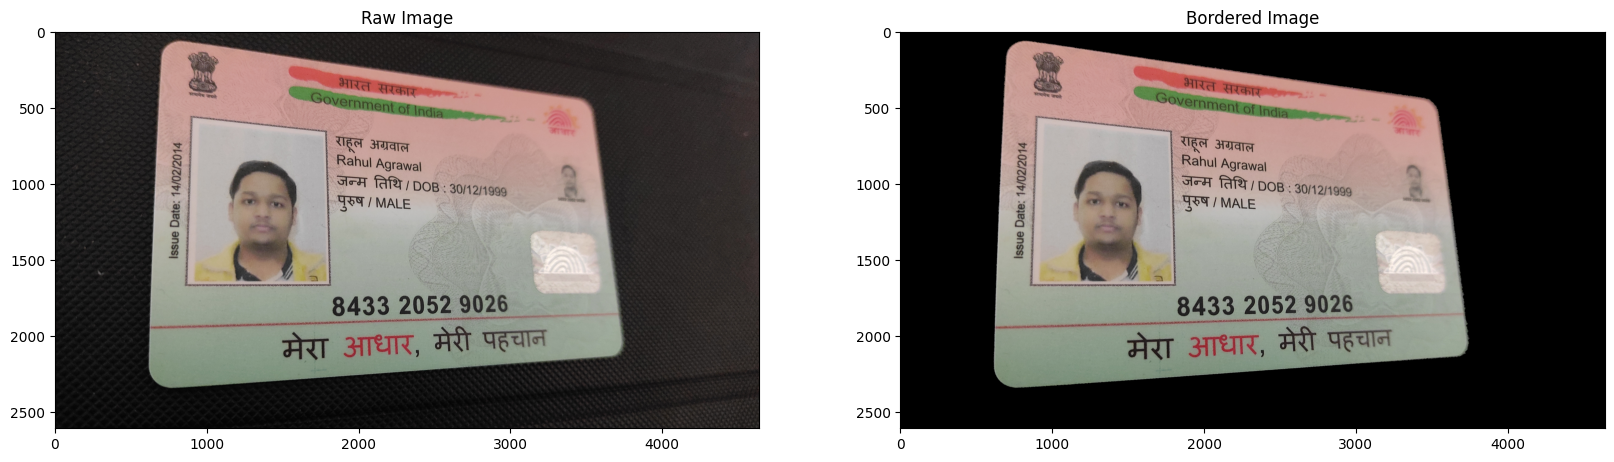

In [77]:
# Load image
image = cv2.imread('datasets\demo_rahul_projective.jpg').astype(np.uint8)

# Get contours
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the image
blur = cv2.GaussianBlur(gray, (5,5), 0)

# Apply a threshold to the blurred image
_, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret, thresh = cv2.threshold(gray, int(image[:, :, 0].mean()), int(image[:, :, 1].mean()), 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find contour with largest area
max_contour = max(contours, key=cv2.contourArea)

# Draw contour on black background image
mask = np.zeros_like(gray)
cv2.drawContours(mask, [max_contour], 0, (255, 255, 255), -1)

# Extract bordered image using mask
bordered_image = cv2.bitwise_and(image, image, mask=mask)

 # Plot the two images side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Raw Image")
ax[1].imshow(cv2.cvtColor(bordered_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("Bordered Image")
plt.show()


### Applying Canny Edge and Hough Line Transform to gain edges angle and perform rotation

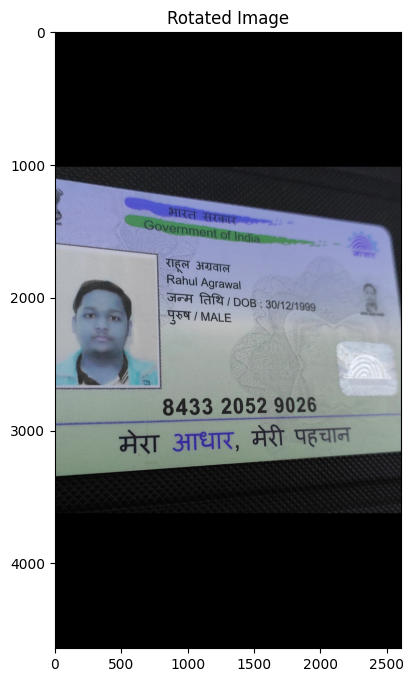

In [78]:
# Convert to grayscale
gray = cv2.cvtColor(bordered_image, cv2.COLOR_BGR2GRAY)

# Apply canny edge detection
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Apply Hough line transform
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

# Find angles of lines with respect to horizontal axis
angles = []
for line in lines:
    rho, theta = line[0]
    if theta > np.pi/2:
        theta -= np.pi
    angle = np.degrees(theta)
    angles.append(angle)

# Rotate image by average angle
avg_angle = np.min(angles)
rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_180)

rows, cols = rotated_image.shape[:2]
M = cv2.getRotationMatrix2D((cols/2, rows/2), avg_angle, 1)
rotated_image = cv2.warpAffine(rotated_image, M, (cols, rows))

show_image("Rotated Image", rotated_image)

### Taking the max contour area as our desired object and again removing background on the rotated image

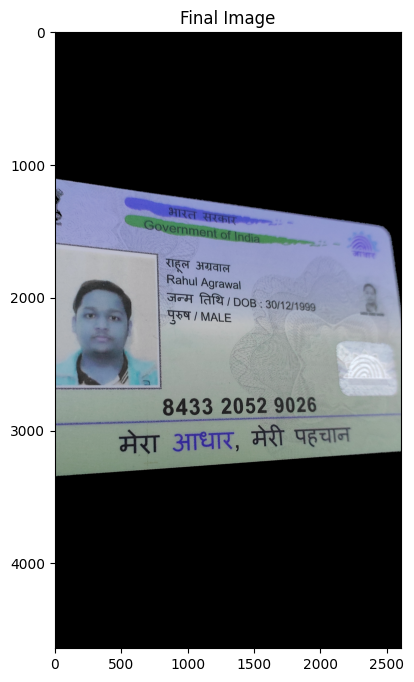

In [79]:
# Get contours
gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, int(image[:, :, 0].mean()), int(image[:, :, 1].mean()), 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find contour with largest area
max_contour = max(contours, key=cv2.contourArea)

# Draw contour on black background image
mask = np.zeros_like(gray)
cv2.drawContours(mask, [max_contour], 0, (255, 255, 255), -1)

# Extract bordered image using mask
final_image = cv2.bitwise_and(rotated_image, rotated_image, mask=mask)

show_image("Final Image", final_image)

### Applying canny edge again to gain new edges on the rotated image

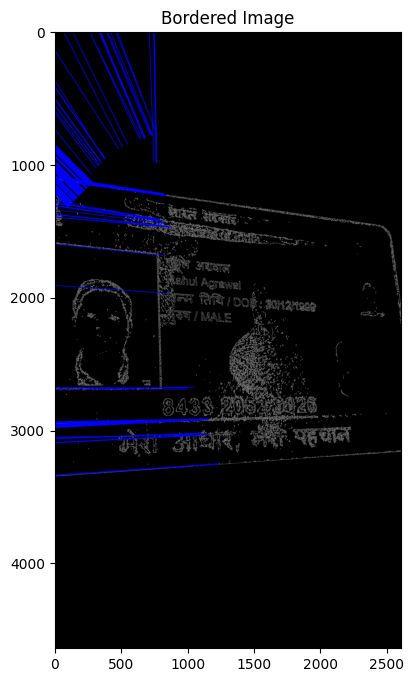

In [80]:
import math

# Convert to grayscale
gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)

# Apply canny edge detection
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
dstp = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

# Apply Hough line transform
lines = cv2.HoughLines(edges, 1, np.pi/180, 330)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        cv2.line(dstp, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
        
show_image("Bordered Image", dstp)

### Cropping the image based on the edges gained

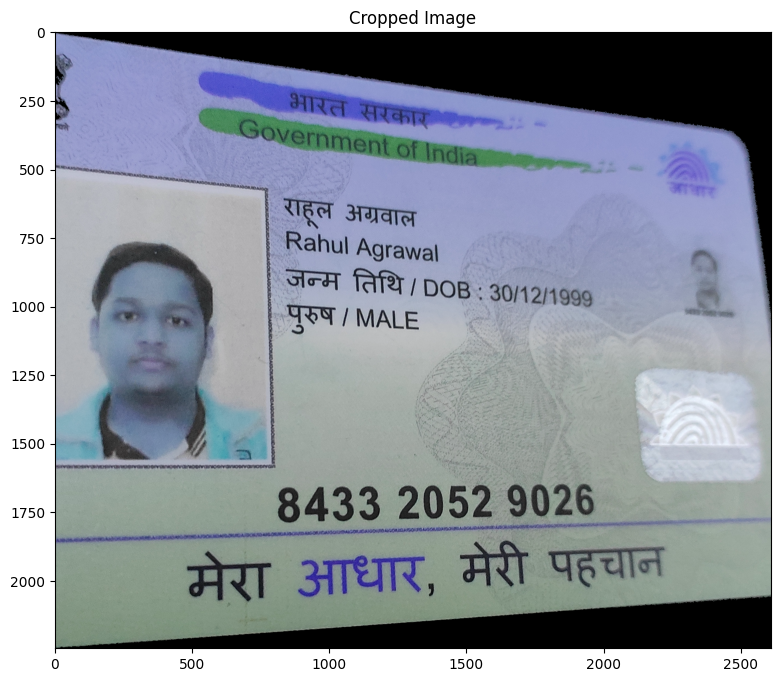

In [81]:
gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(largest_contour)
crop_img = final_image[y:y+h, x:x+w]
show_image("Cropped Image", crop_img)

### Detecting the contours and bordering the image

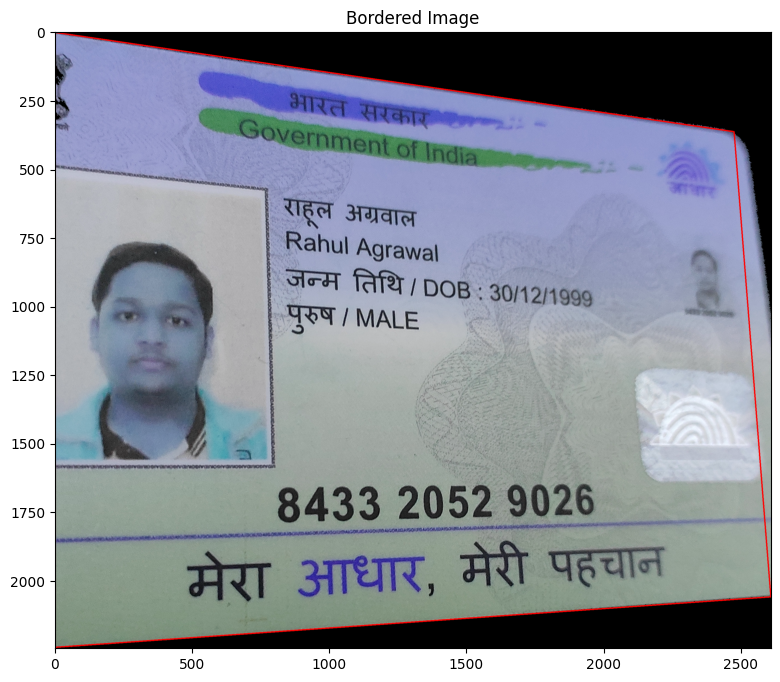

In [82]:
gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

for contour in contours:
    # we approximate the contour
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * peri, True)
    # if we found a countour with 4 points we break the for loop
    # (we can assume that we have found our document)
    if len(approx) == 4:
        doc_cnts = approx
        break
        
# We draw the contours on the original image not the modified one
all_contours = crop_img.copy()
cv2.drawContours(all_contours, [doc_cnts], -1, (255, 0, 0), 3)

show_image("Bordered Image", all_contours)

### Helper functions to apply four-point transform on the image

In [83]:
def order_points(pts):
    # initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

### Sharpening the Image

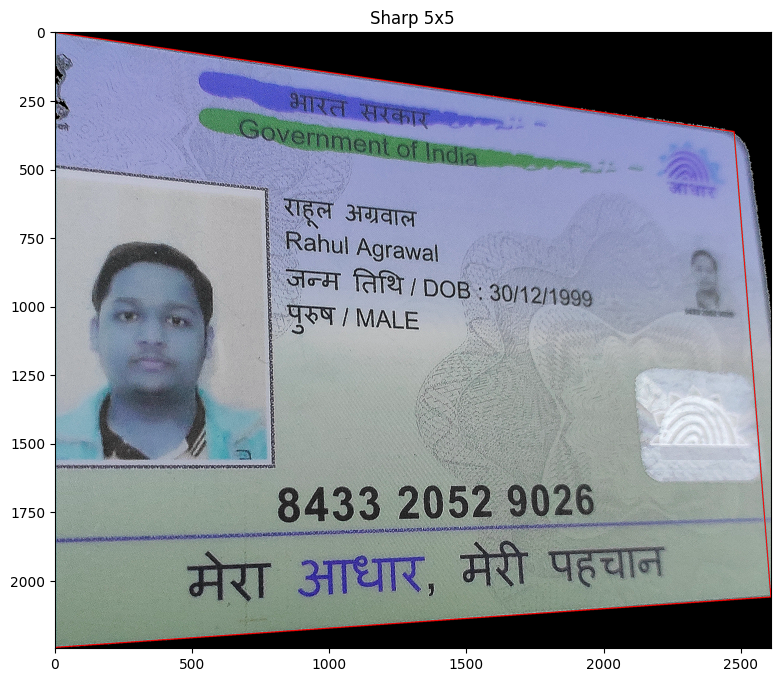

In [84]:
def unsharp_mask(image, kernel_size=(3, 3), sigma=20.0, amount=10.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

sharp = unsharp_mask(all_contours)
show_image("Sharp 5x5", sharp)

In [85]:
warped = four_point_transform(sharp, doc_cnts.reshape(4, 2))
warped_color = warped.copy()
# convert the warped image to grayscale
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
# Extracting text from cropped image
out_below = pytesseract.image_to_string(warped)
print(out_below)

In [86]:
# # show_image("kajsnfd", sharp)
# cv2.imshow("Output", sharp)
# cv2.waitKey(0)

In [87]:
cv2.imwrite("final.jpg", sharp)

True

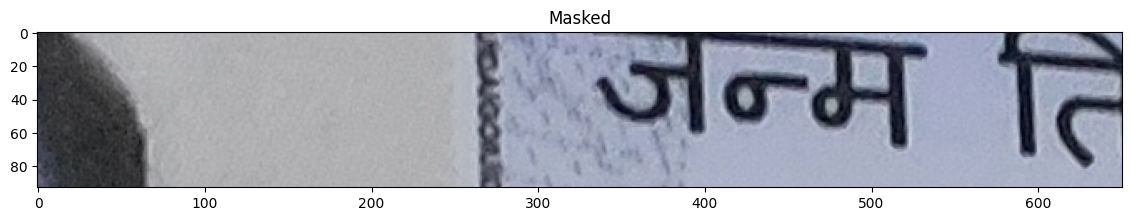

In [88]:
imgShow = all_contours.copy()
imgMask = np.zeros_like(imgShow)
x0 = 509
y0 = 872
x1 = 1160
y1 = 965

cv2.rectangle(imgMask, (x0, y0), (x1, y1), (255, 255, 255), cv2.FILLED)
imgShow = cv2.addWeighted(imgShow, 0.99, imgMask, 0.2, 0)

imgCrop = all_contours[y0:y1, x0:x1]

show_image("Masked", imgCrop)

In [89]:
print(pytesseract.image_to_string(imgCrop))

## **3. Trying to read text using PyTesseract and failing miserably**

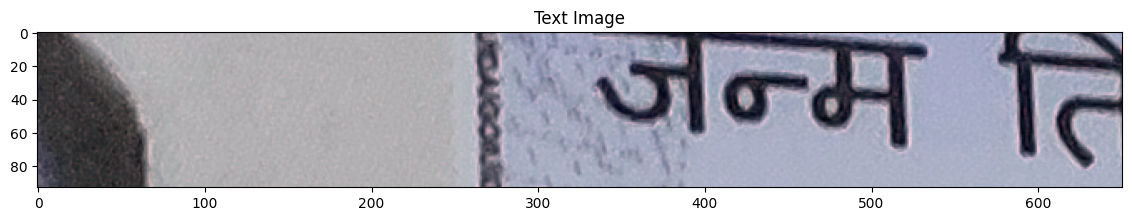

In [90]:
blur = cv2.GaussianBlur(imgCrop, (5, 5), 0)

# Subtract the blurred image from the original image to get an edge mask
edge_mask = cv2.subtract(imgCrop, blur)

# Scale the edge mask to increase the intensity of the edges
edge_mask = cv2.multiply(edge_mask, 2)

# Add the edge mask back to the original image to sharpen it
sharpened = cv2.add(imgCrop, edge_mask)

show_image("Text Image", sharpened)

### Getting no output in reading text

In [91]:
print(pytesseract.image_to_string(sharpened))

## **An Insight why we failed to extract the Aadhar Number and the intuition of SIFT Feature Mapping**

#### *The reason we failed here is because PyTesseract does not know where to look for the text which we are trying to extract. We don't know the precise location of the text.*
#### *Now we want to know the exact location of the text which we want to read. To do that, we will use SIFT feature extraction to extract necessary features from the input image, and match it with a base image which we will use to extract features from the input image. This will allow us to pinpoint the bounding box of the aadhar number in the input image and will help in text detection part more precisely, as there would be a significant reduction in the noise, for the PyTesseract to perform text extraction from the image.*



## **4. SIFT Feature Detection on base image**

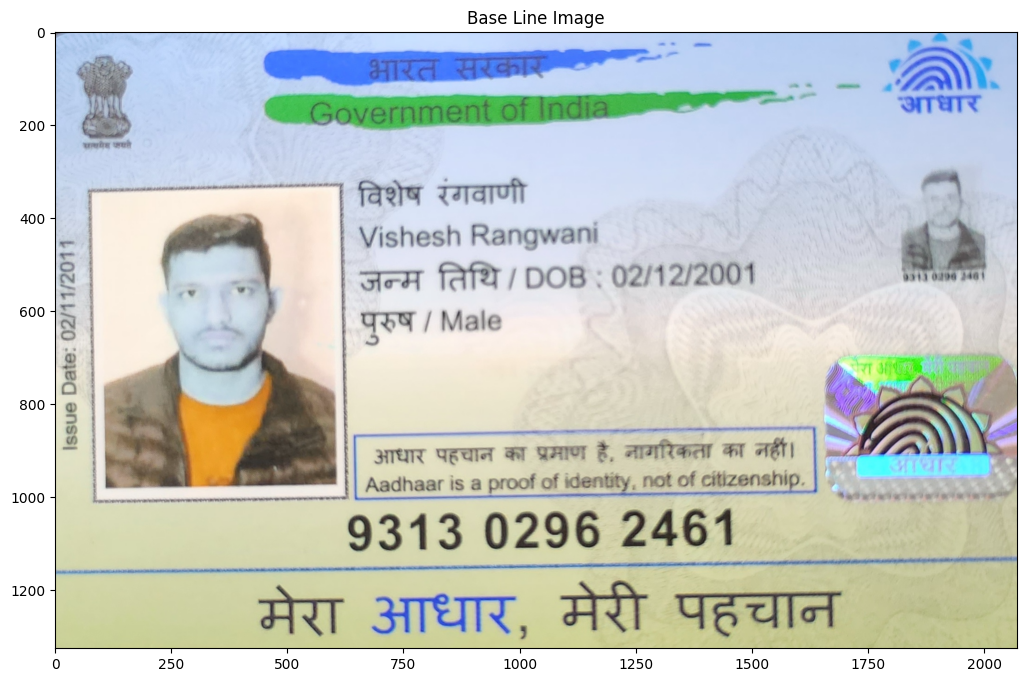

In [92]:
imgQ = cv2.imread('datasets\query_image.jpg')

height, width, _ = imgQ.shape
show_image("Base Line Image", imgQ)

### Detecting key features in the base image

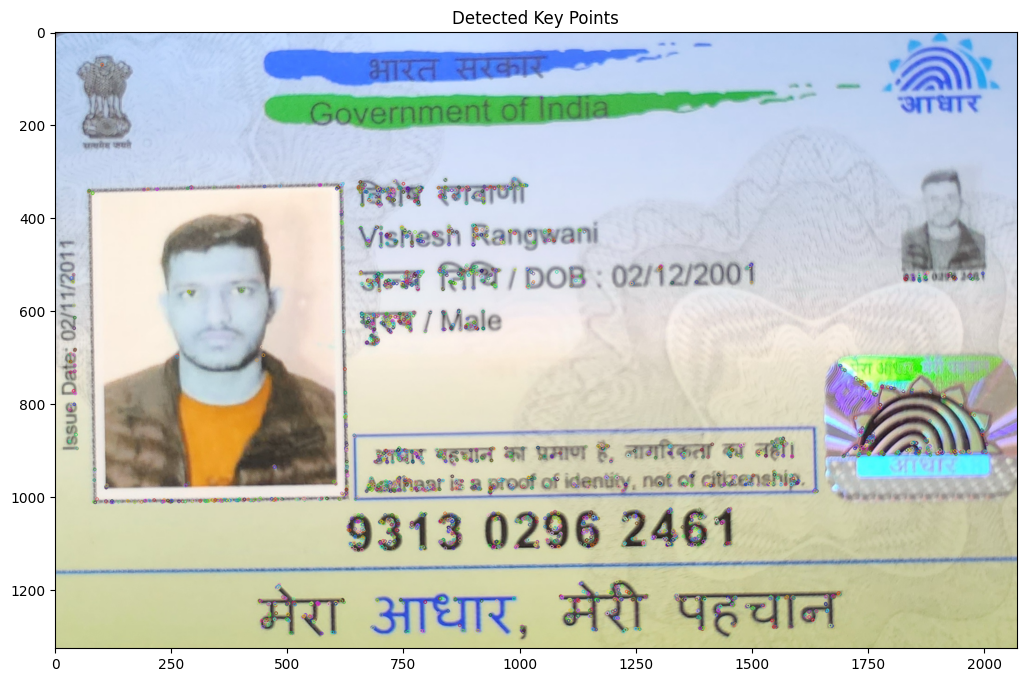

In [93]:
sift = cv2.SIFT_create(5000)
orb = cv2.ORB_create(5000)
keypoints1, des1 = orb.detectAndCompute(imgQ, None)

imgkp1 = cv2.drawKeypoints(imgQ, keypoints1, None)

show_image("Detected Key Points", imgkp1)


## **5. SIFT Feature Detection on input image**

### Performing boundary detection on the input image now

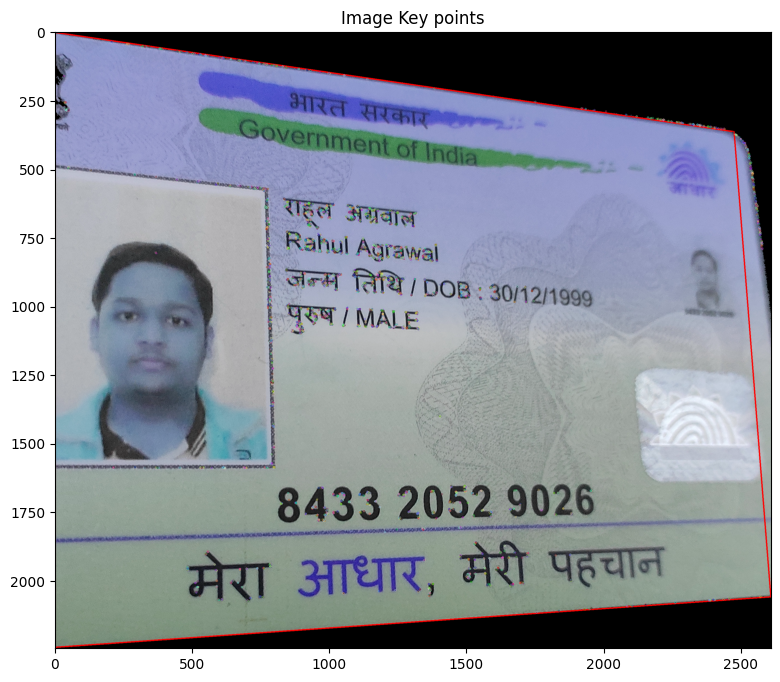

In [94]:
img2 = all_contours.copy()
kp2, des2 = orb.detectAndCompute(img2, None)

imgkp2 = cv2.drawKeypoints(img2, kp2, None)
show_image("Image Key points", imgkp2)

## **6. Performing the SIFT FEATURE MATCHING of the input image with our base image**

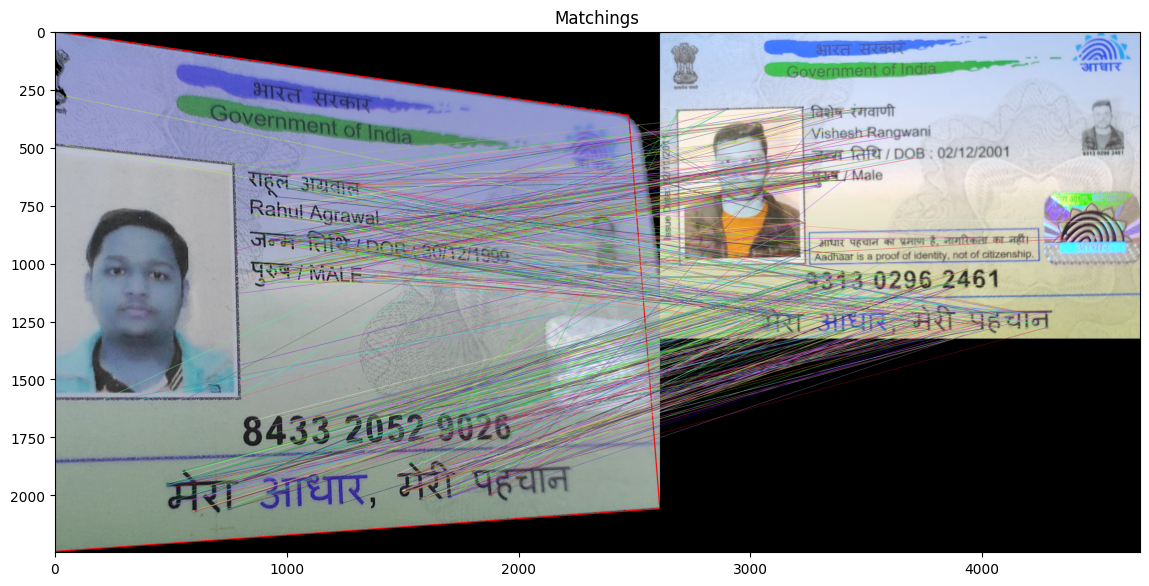

In [95]:
# Determining the matching percentage
per = 10

# Matching the features using BRUTE FORCE MATCHER & using HAMMING distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING2)
matches = bf.match(des2, des1)
matches_list = list(matches)
matches_list.sort(key= lambda x: x.distance)
good_matches = matches_list[:int(len(matches)*(per/100))]
imgMatch = cv2.drawMatches(img2, kp2, imgQ, keypoints1, good_matches,  None, flags=2)

show_image("Matchings", imgMatch)


### Computing the Homography Matrix for orienting the image using RANSAC

In [96]:
srcPoints = np.float32([kp2[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dstPoints = np.float32([keypoints1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

matrix_M, _ = cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC, 5.0)

### Reorienting the image

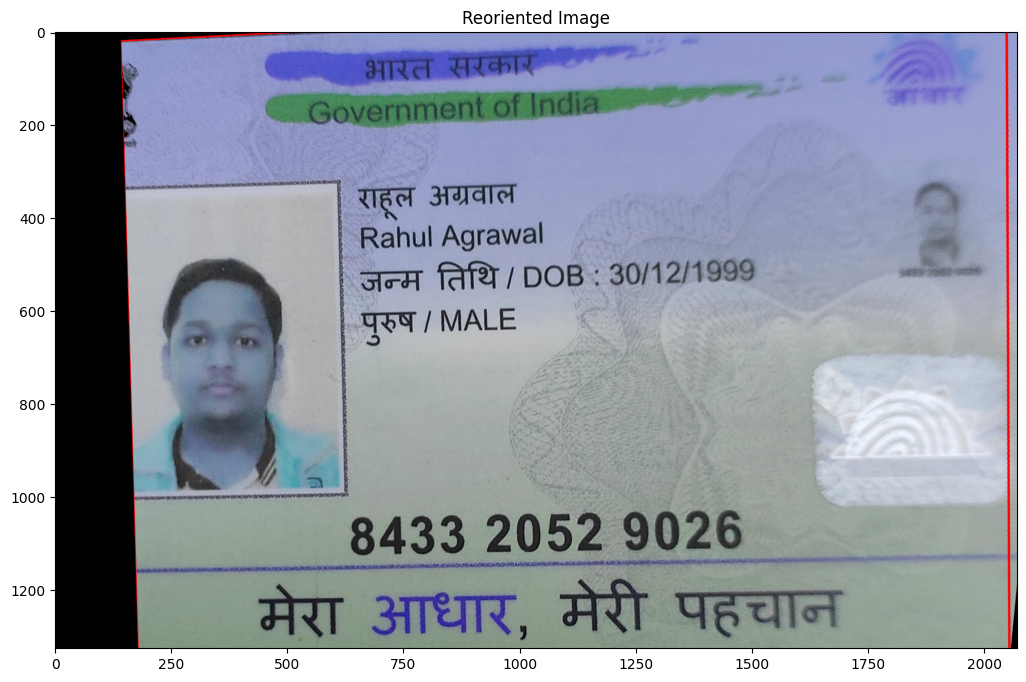

In [97]:
# Aliging the images using the matrix:

imgScan = cv2.warpPerspective(img2, matrix_M, (width, height))
show_image("Reoriented Image", imgScan)

## **6. Using SIFT Feature Matching, cropping only the necessary feature which we require**

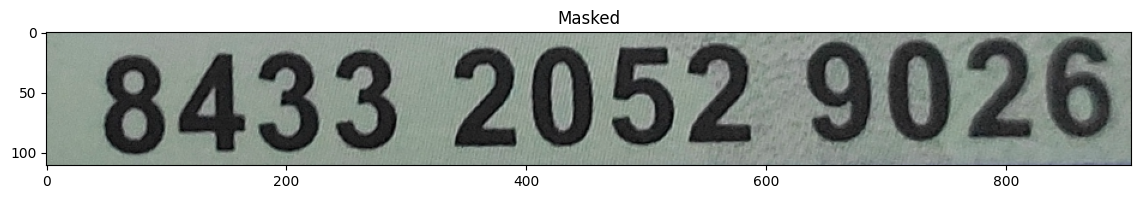

In [98]:
imgShow = imgScan.copy()
imgMask = np.zeros_like(imgShow)
x0 = 588
y0 = 1024
x1 = 1493
y1 = 1135

cv2.rectangle(imgMask, (x0, y0), (x1, y1), (255, 255, 255), cv2.FILLED)
imgShow = cv2.addWeighted(imgShow, 0.99, imgMask, 0.2, 0)

imgCrop = imgScan[y0:y1, x0:x1]

show_image("Masked", imgCrop)

## **7. Using PyTesseract to read the text from image**

In [99]:
print("Detecting Aadhar number using pytesseract....")
detected_aadhar_no = pytesseract.image_to_string(imgCrop)
print("Aadhar Detected Successfully..\n")
print("Detected Aadhar Number: ", detected_aadhar_no)
detected_aadhar_no = detected_aadhar_no[:-1]

Detecting Aadhar number using pytesseract....
Aadhar Detected Successfully..

Detected Aadhar Number:  8433 2052 9026



## **8. Validating the Aadhar Number using Aadhar API**

In [100]:
authResponse = AuthResponse(uid=str(detected_aadhar_no))
print("Aadhar Status : ", authResponse.validate())

843320529026
Aadhar Status :  Valid Aadhar Number
